# Non Linear Regression

## Decision Tree

A decision tree is a predictor h: X --> Y, that predicts the label y associated with an observation x by travelling from root node of a tree to a leaf. At each node on the root-to-leaf path, the successor child is chosen by a "best split". 

A best split of the parent node chooses the best feature to split and the best threshold the input space could be splitted with respect to the best feature. To compute the best split, we iterate over all features and all feature values. For each combination of feature and feature value the information gain that could be achieved by the split is computed.

For classification normaly Entropy or Gini Incdex is used. For Regression Variance or Standard Deviation ist uses as splitting rule.

Variance:

The variance is the average of the squared differences from the mean. 
To figure out the variance, first calculate the difference between each point and the mean; 
then, square and average the results.

Standard Deviation:

Standard deviation is a statistic that looks at how far from the mean a group of numbers is, by using the square root of the variance. The calculation of variance uses squares because it weights outliers more heavily than data very near the mean. This calculation also prevents differences above the mean from canceling out those below, 
which can sometimes result in a variance of zero.

In [1]:
###### some preliminary things

# entropy is a measure of disorder
# 
# Entropy H = - SUM_(p(Y) * ln(p(Y)))   
#
#          #y
# p(X) = ----- (Häufigkeit), n number of classes oder target values
#          n
#
# information gain is defined as 
#
# IG: = Entropy(parent) - [weighted_average] Entropy(children)
#
# If parent entropy is higher then weighted sum of the child entropies than disorder is lesser after the split. 
# The input space was splitted into two more homogeneous regions with respect to the outcome (target values).
#

In [2]:
import numpy as np
from collections import Counter

In [3]:
class Node():
    """
    a node constist of the following information:
    
    feature     - to which featrue the tree split (division) takes place
    threshold   - value of the featre the split takes place 
    left        - left node we are pointing to
    right       - right node we are pointing to
    value       - the value of the node, if the node is a leaf node
    
    
                             node
                             
                leftNode              rightNode
     
    
    """
    def __init__(self, feature=None, threshold=None, 
                 left=None, right=None, measure=None, *, value=None): # * have to pass value by name, value will only passed to leaf nodes
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.measure = measure
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None
    
    def __str__(self):
        return f"({self.feature=},{self.threshold=}, {self.left=}, {self.right=}, {self.measure=}, {self.value=})" 

# Classification with Decision Tree

In [29]:
class ClassificationDecisionTree():
    
    
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.root=None
        
        
    def fit(self, X, y):
        """learn the tree""" 
        self.root = self._grow_tree(X, y)
    
    
    def _grow_tree(self, X, y, depth=0):
        """this function builds the tree."""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        #check stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)
        
        feature_idxs = np.random.choice(n_features, n_features, replace=False)
        
        #find best split
        best_feature, best_threshold = self._best_split(X, y, feature_idxs)
        
        #create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        
        if best_threshold is None:
            print(best_feature, best_threshold)            

        measure = self._entropy(y)
        
        new_node = Node(best_feature, best_threshold, left, right, measure)
        
                    
        if left is None or right is None:
            print(new_node)
            
        return new_node
    
        
    
    def _best_split(self, X, y, feature_idxs):
        best_gain = -float("inf")
        split_idx, split_threshold = None, None
        
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
                    
        return split_idx, split_threshold
        
    
    def _information_gain(self, y, X_column, threshold):
        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if (len(left_idxs) == 0 or len(right_idxs) == 0):
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
               
        # parent entropy
        parent_entropy = self._entropy(y)

        #calculate the weighted average entropy of the children
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])

        return parent_entropy - (n_l/n * e_l + n_r/n * e_r)
        
        
    def _entropy(self, y):
        histogram = np.bincount(y)
        ps = histogram / len(y)
        return - sum(p * np.log(p) for p in ps if p > 0)
        
    def _split(self, X_column, threshold):
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs
        
    def _calculate_leaf_value(self, y):
        return self._most_common_label(y)

    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
            
    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])
    
    def _traverse(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if node.threshold is None:
            print(node)
        
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)


In [30]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y= data.data, data.target

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(569, 30)


In [31]:
dt = ClassificationDecisionTree() #min_samples_split=20, max_depth=25, n_features=X.shape[0])
dt.fit(X_train, y_train)

#print("Root",dt.root)

predictions = dt.predict(X_test)

def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

acc = accuracy(y_test, predictions)

print(acc)

0.9385964912280702


# Regression with Decision Tree

In [32]:
class RegressionDecisionTree():

    
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.root=None
        
        
    def fit(self, X, y):
        """learn the tree"""  
        self.root = self._grow_tree(X, y)
    
    
    def _grow_tree(self, X, y, depth=0):
        """this function builds the tree."""
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        #check stopping criteria
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)
        
        feature_idxs = np.random.choice(n_features, n_features, replace=False)
        
        #find best split
        best_feature, best_threshold = self._best_split(X, y, feature_idxs)
        
        #create child nodes
        left_idxs, right_idxs = self._split(X[:,best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs,:], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs,:], y[right_idxs], depth+1)
        
        if best_threshold is None:
            print(best_feature, best_threshold)            

        measure = self._variance(y)
        
        new_node = Node(best_feature, best_threshold, left, right, measure)
        
                    
        if left is None or right is None:
            print(new_node)
            
        return new_node
    
        
    
    def _best_split(self, X, y, feature_idxs):
        best_gain = -float("inf")
        split_idx, split_threshold = None, None
        
        for feature_idx in feature_idxs:
            X_column = X[:, feature_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, threshold)
                
                if gain > best_gain:
                    best_gain = gain
                    split_idx = feature_idx
                    split_threshold = threshold
                    
        return split_idx, split_threshold
        
    
    def _information_gain(self, y, X_column, threshold):
        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if (len(left_idxs) == 0 or len(right_idxs) == 0):
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
                
        parent_variance = self._variance(y)

        #calculate the weighted average entropy of the children
        var_l, var_r = self._variance(y[left_idxs]), self._variance(y[right_idxs])

        return parent_variance - (n_l/n * var_l + n_r/n * var_r)
        
    def _variance(self, y):
        return np.var(y)
    
    def _split(self, X_column, threshold):
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs
        
    def _calculate_leaf_value(self, y):
        return np.mean(y)
           
    
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
        
    
    def predict(self, X):
        return np.array([self._traverse(x, self.root) for x in X])
    
    def _traverse(self, x, node):
        if node.is_leaf_node():
            return node.value
        
        if node.threshold is None:
            print(node)
        
        if x[node.feature] <= node.threshold:
            return self._traverse(x, node.left)
        else:
            return self._traverse(x, node.right)        

In [33]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.fetch_california_housing(data_home=None, download_if_missing=True, 
                                         return_X_y=False, as_frame=False)

X, y= data.data, data.target

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

(20640, 8)


In [34]:
dt = RegressionDecisionTree(max_depth=2)

dt.fit(X_train, y_train)

In [36]:
from sklearn.metrics import mean_squared_error

predictions = dt.predict(X_train)
print(mean_squared_error(y_train, predictions))

predictions = dt.predict(X_test)
print(mean_squared_error(y_test, predictions))

0.7324946684204919
0.754263509603161


In [17]:
print(predictions[0:10])
print(y_test[0:10])

[1.35798601 1.35798601 2.0900204  2.95372463 2.0900204  2.0900204
 2.0900204  2.0900204  2.0900204  4.26226159]
[0.477   0.458   5.00001 2.186   2.78    1.587   1.982   1.575   3.4
 4.466  ]


## Challenges with Decision Trees

In [37]:
###### generate test data ########
def random_sinus_data():
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(100,1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(20)) # try with and without random error
    return X, y 

X, y = random_sinus_data()

print(X.shape)
print(y.shape)

(100, 1)
(100,)


In [39]:
dt1 = RegressionDecisionTree(max_depth=2)
dt1.fit(X,y)
dt2 = RegressionDecisionTree(max_depth=5)
dt2.fit(X,y)
dt3 = RegressionDecisionTree(max_depth=10)
dt3.fit(X,y)


X_test = np.linspace(0,5,100).reshape(100,1)
print(X_test.shape)

y_1 = dt1.predict(X_test)
y_2 = dt2.predict(X_test)
y_3 = dt3.predict(X_test)

(100, 1)


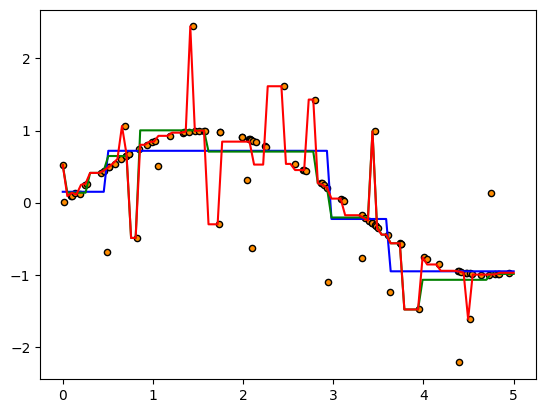

In [40]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
ax.plot(X_test, y_1, color="blue", label="max_depth=2")
ax.plot(X_test, y_2, color="green", label="max_depth=5")
ax.plot(X_test, y_3, color="red", label="max_depth=10")


plt.show()